In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
import librosa
from librosa import display
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from IPython.display import HTML, Audio, display_html
from tqdm import tqdm
%matplotlib inline
from multiprocessing import Process, Pool

In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
train_df.head()

Unnamed: 0             wav_path   label  target
0           0  train/c/1c306fb.wav   music       1
1           1  train/e/3480542.wav  speech       0
2           2  train/3/431313a.wav   noise       2
3           3  train/a/7856ac7.wav   music       1
4           4  train/6/be92480.wav   noise       2

In [49]:
path = train_df.iloc[3].wav_path

In [50]:
x, sr = librosa.load(path, sr=16000)

In [41]:
Audio(path, rate=16000)

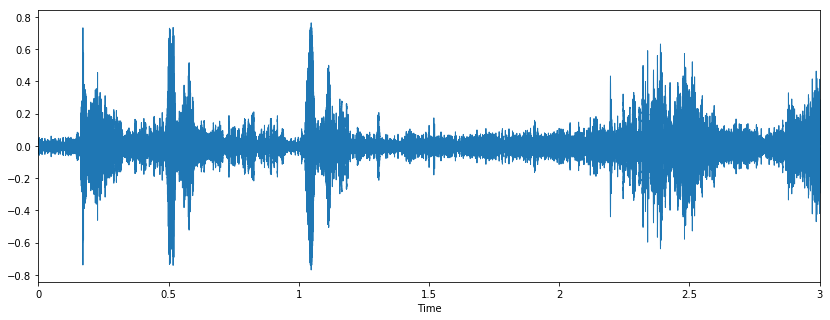

In [38]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

(32.0, 23072.0, 0.0, 1.0)

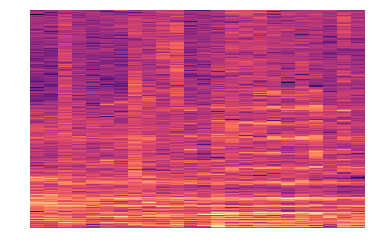

In [51]:
cmap = plt.get_cmap('magma')
plt.specgram(x, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB')
plt.axis('off')

In [3]:
header = 'chroma_stft rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header = header.split()

%time
df_test = pd.DataFrame()
df_test['kek'] = [1,2,3,4,5]
s = df_test.shape[0]
df_test['lol'] = np.zeros(s)
for h in header:
    df_test[h] = np.zeros(s)

df_kek = df_test.copy()
df_test.at[4,'kek'] = 2
i = 0
for r in df_test.kek:
    df_test.at[i,'rmse'] = i+10
    i+=1
lol = [9,8,7,6,5]
df_test.kek = lol
lol[0] = 444
df_test

In [4]:
my_train_df = train_df.copy()
size = train_df.shape[0]
for h in header:
    my_train_df[h] = np.zeros(size)

In [5]:
def fill_rms_chroma_stft(y, sr, i):
    my_train_df.at[i,'rms'] = np.mean(librosa.feature.rms(y=y))
    my_train_df.at[i,'chroma_stft'] = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))

def fill_spectral_centroid_bandwidth(y, sr, i):
    my_train_df.at[i,'spec_cent'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    my_train_df.at[i,'spec_bw'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))

def fill_spectral_rolloff_zcr(y, sr, i):
    my_train_df.at[i,'rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    my_train_df.at[i,'zcr'] = np.mean(librosa.feature.zero_crossing_rate(y))

def fill_mfcc(y, sr, i):
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    j = 1
    for e in mfcc:
        my_train_df.at[i,'mfcc'+str(j)] = np.mean(e)
        j+=1

i = 0
fills = [fill_rms_chroma_stft, fill_spectral_centroid_bandwidth, fill_spectral_rolloff_zcr, fill_mfcc]
for path in tqdm(my_train_df.wav_path):
    y, sr = librosa.load(path, sr=16000)
    pool = Pool()
    pool.map(fills, (y, sr, i))
    i+=1


i = 0
fills = [fill_rms_chroma_stft, fill_spectral_centroid_bandwidth, fill_spectral_rolloff_zcr, fill_mfcc]
for path in tqdm(my_train_df.wav_path):
    y, sr = librosa.load(path, sr=16000)
    procs = []
    for fill in fills:
        proc = Process(target=fill, args=(y,sr,i))
        procs.append(proc)
        proc.start()
    
    for proc in procs:
        proc.join()

    i += 1

In [ ]:
i = 0
for path in tqdm(my_train_df.wav_path):
    y, sr = librosa.load(path, sr=16000)
    rms = np.mean(librosa.feature.rms(y=y))
    my_train_df.at[i,'rms'] = rms

    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    my_train_df.at[i,'chroma_stft'] = chroma_stft

    spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    my_train_df.at[i,'spec_cent'] = spec_cent

    spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    my_train_df.at[i,'spec_bw'] = spec_bw

    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    my_train_df.at[i,'rolloff'] = rolloff

    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    my_train_df.at[i,'zcr'] = zcr

    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    j = 1
    for e in mfcc:
        my_train_df.at[i,'mfcc'+str(j)] = np.mean(e)
        j+=1
    i+=1

In [ ]:
d = ['1','2','3','4','5','6','7','8','9','0','a','b','c','d','e','f']
for i in d:
    os.mkdir('img_train/'+i)

In [42]:
'img_'+my_train_df.iloc[0].wav_path.split('.')[0]+'.png'

'img_train/c/1c306fb.png'

In [ ]:
cmap = plt.get_cmap('magma')
i = 0
for path in tqdm(my_train_df.wav_path):
    img_path = 'img_' + path.split('.')[0] + '.png'
    x, _ = librosa.load(path, sr=16000)
    plt.specgram(x, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB')
    plt.axis('off')
    plt.savefig(img_path, dpi=20, bbox_inches = 'tight', pad_inches=0)
    plt.close()

In [75]:
sbmt_df=pd.read_csv('sample_submission.csv')

In [76]:
header = 'chroma_stft rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header = header.split()

In [77]:
my_sbmt_df = sbmt_df.copy()
size = sbmt_df.shape[0]
for h in header:
    my_sbmt_df[h] = np.zeros(size)

In [78]:
i = 0
for path in tqdm(my_sbmt_df.wav_path):
    y, sr = librosa.load(path, sr=16000)
    rms = np.mean(librosa.feature.rms(y=y))
    my_sbmt_df.at[i,'rms'] = rms

    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    my_sbmt_df.at[i,'chroma_stft'] = chroma_stft

    spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    my_sbmt_df.at[i,'spec_cent'] = spec_cent

    spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    my_sbmt_df.at[i,'spec_bw'] = spec_bw

    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    my_sbmt_df.at[i,'rolloff'] = rolloff

    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    my_sbmt_df.at[i,'zcr'] = zcr

    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    j = 1
    for e in mfcc:
        my_sbmt_df.at[i,'mfcc'+str(j)] = np.mean(e)
        j+=1
    i+=1

100%|██████████| 55200/55200 [55:37<00:00, 16.54it/s]


In [81]:
my_sbmt_df.drop(columns=['target', 'spectral_centroid', 'spectral_bandwidth', 'zero_crossing_rate']).to_csv('my_sbmt.csv', index=False)

In [82]:
my_sbmt_df = pd.read_csv('my_sbmt.csv')

wav_path  chroma_stft       rms      rolloff       mfcc1  \
0      val/e/b7cf2c4.wav     0.496027  0.017240  4902.177527 -324.276367   
1      val/0/8f1489d.wav     0.464079  0.009193  4338.347739 -335.256622   
2      val/f/14b7304.wav     0.451287  0.036937  2064.577793 -361.271179   
3      val/2/3763132.wav     0.470376  0.028705  4571.309840 -315.734283   
4      val/0/51c4271.wav     0.261021  0.051054  1828.540559 -288.413910   
...                  ...          ...       ...          ...         ...   
55195  val/1/0564de3.wav     0.406101  0.015770  3687.167553 -333.506683   
55196  val/8/35d87ad.wav     0.609413  0.003299  4159.906915 -574.424133   
55197  val/f/6135083.wav     0.327847  0.059146  2303.773271 -290.275421   
55198  val/6/2a6a3ad.wav     0.310489  0.058222  2898.686835 -246.662918   
55199  val/f/484933c.wav     0.346058  0.045552  4028.174867 -225.783279   

            mfcc2      mfcc3      mfcc4      mfcc5      mfcc6  ...    mfcc14  \
0       49.990807  -8.178071  14.912135 -17.682041 -10.042214  ...  4.253848   
1       90.426102 -42.100540  82.256760 -71.833382  64.855072  ... -5.222099   
2      126.436501   3.728551  49.737129   2.259181   3.688420  ...  6.468022   
3       51.387966  10.583009  27.717169  11.548429  11.581113  ...  3.024768   
4      168.178421   5.767138   4.083038 -13.092202  -0.515463  ...  6.999194   
...           ...        ...        ...        ...        ...  ...       ...   
55195   96.769440 -14.361953  35.166199  -6.110136 -17.329939  ...  5.490494   
55196   80.401123  23.264009  19.718275  10.709662   9.887084  ... -0.169609   
55197  139.898117 -66.284500  53.202637 -15.089040 -22.518227  ... -3.504283   
55198  113.350960   2.157320   0.120811 -18.053900 -16.515942  ... -7.053052   
55199   68.344589 -27.832174  15.944839 -16.239735 -36.648335  ... -2.453742   

          mfcc15     mfcc16    mfcc17    mfcc18     mfcc19     mfcc20  \
0      -7.529153  -2.386624 -7.638331  4.196908 -11.129672  -0.017556   
1       7.283256  -8.595081  4.465259 -9.179503   6.654512 -10.148501   
2      -1.942776  -2.708264  1.105576 -3.353041  -5.226191   0.182690   
3      -3.772561   0.007143 -1.386284 -0.458001   1.109095  -0.120524   
4      11.872687   7.835423 -1.145010 -6.657090  -5.438885  -0.046861   
...          ...        ...       ...       ...        ...        ...   
55195   1.803399 -10.101019  3.722016 -0.427385 -15.349832   4.606675   
55196   1.520458   0.188386 -0.615289 -0.078319   0.134703  -0.146046   
55197   3.869452  -8.650487  3.379713 -1.203597  -3.387620   0.597551   
55198  -7.778873  -5.640789 -5.533044 -7.923006  -0.348279  -8.395930   
55199 -15.007978   0.106602 -5.409209 -4.177210  -3.120730  -8.956707   

         spec_cent      spec_bw       zcr  
0      2463.652741  2055.476923  0.197079  
1      2656.996559  1612.008225  0.297836  
2       985.497143  1224.802636  0.066006  
3      2354.626658  2003.314093  0.154816  
4      1037.445705  1168.792912  0.078920  
...            ...          ...       ...  
55195  1820.375016  1672.602927  0.140661  
55196  1920.491246  2006.814989  0.131337  
55197  1496.127720   991.750310  0.160696  
55198  1591.522393  1545.765080  0.133825  
55199  2199.126874  1787.059542  0.174602  

[55200 rows x 27 columns]

In [2]:
my_train_df = pd.read_csv('my_train.csv')
my_train_df.head()

wav_path   label  target  chroma_stft      rmse      rolloff  \
0  train/c/1c306fb.wav   music       1     0.446180  0.145849  5678.607048   
1  train/e/3480542.wav  speech       0     0.289166  0.079963  3412.815824   
2  train/3/431313a.wav   noise       2     0.548665  0.081080  2580.950798   
3  train/a/7856ac7.wav   music       1     0.279874  0.130335  4446.143617   
4  train/6/be92480.wav   noise       2     0.342376  0.110688  3837.849069   

        mfcc1       mfcc2      mfcc3      mfcc4  ...    mfcc14     mfcc15  \
0  -19.775450   42.010422  17.328161  29.757710  ...  0.093620  -6.125071   
1 -288.626129   63.135723  40.723434  44.627357  ... -1.269506  -8.662362   
2 -182.877823  162.961349 -73.814285  72.400642  ...  3.478594  -8.773681   
3  -51.592831   70.468826  -2.028518  10.674696  ... -2.919339  -8.003991   
4 -122.986107   91.162766  -9.262664  10.427245  ...  9.649744 -15.828825   

     mfcc16    mfcc17    mfcc18     mfcc19     mfcc20    spec_cent  \
0 -4.988477 -1.811290 -4.959956  -6.247894  -3.638346  2720.922756   
1 -2.471177 -3.570199 -7.281505  -2.870191  -3.437265  1715.149498   
2 -4.314072  2.566931 -7.937404   6.641366  -1.491071  1296.559497   
3 -1.788871  8.375018  4.354144 -15.499653 -14.498023  2179.611451   
4  7.522818 -5.743901  4.721338 -13.536825   3.746032  1813.892379   

       spec_bw       zcr  
0  2333.511727  0.188383  
1  1787.059523  0.125182  
2  1094.329522  0.125582  
3  1992.287694  0.159424  
4  1780.665801  0.132651  

[5 rows x 29 columns]

In [29]:
my_train_df.describe()

target    chroma_stft          rmse        rolloff  \
count  273000.000000  273000.000000  2.730000e+05  273000.000000   
mean        1.000000       0.406043  1.054298e-01    3582.635331   
std         0.816498       0.121004  1.018449e-01    1259.184501   
min         0.000000       0.012744  1.731940e-08       7.812500   
25%         0.000000       0.323993  3.603816e-02    2735.455452   
50%         1.000000       0.388036  7.209370e-02    3568.691822   
75%         2.000000       0.477318  1.437441e-01    4457.696144   
max         2.000000       0.902023  9.721970e-01    7997.423537   

               mfcc1          mfcc2          mfcc3          mfcc4  \
count  273000.000000  273000.000000  273000.000000  273000.000000   
mean     -198.575816      91.295728     -10.706867      22.559876   
std       148.244278      43.585732      33.240302      19.454678   
min     -1131.320801    -285.877258    -209.194626    -107.606812   
25%      -290.347023      62.710588     -27.378378      10.836628   
50%      -201.333176      86.893433      -5.812657      21.411695   
75%       -87.118963     115.983269      10.763492      32.733993   
max       203.127747     335.621429     155.202606     138.108795   

               mfcc5          mfcc6  ...         mfcc14         mfcc15  \
count  273000.000000  273000.000000  ...  273000.000000  273000.000000   
mean       -7.402733       3.450449  ...       0.873706      -5.616870   
std        17.894179      14.569724  ...       7.179912       7.514098   
min      -131.693359     -84.099739  ...     -40.425354     -50.910183   
25%       -17.983439      -5.911773  ...      -3.680327     -10.105387   
50%        -5.390343       3.282022  ...       0.553161      -5.107360   
75%         5.040077      12.233204  ...       5.177213      -0.824044   
max       119.553940      97.236153  ...      62.638515      51.210861   

              mfcc16         mfcc17         mfcc18         mfcc19  \
count  273000.000000  273000.000000  273000.000000  273000.000000   
mean       -0.025597      -4.798961      -0.007451      -4.953836   
std         6.787713       6.939102       6.522677       6.434825   
min       -41.325497     -49.567364     -41.283806     -58.573101   
25%        -4.357903      -8.878787      -4.212038      -8.741363   
50%        -0.507066      -4.239849      -0.533386      -4.675665   
75%         3.872102      -0.365100       3.760067      -0.937873   
max        48.456734      51.880848      50.070068      51.260586   

              mfcc20      spec_cent        spec_bw            zcr  
count  273000.000000  273000.000000  273000.000000  273000.000000  
mean        0.180879    1834.232950    1663.507221       0.140765  
std         5.902003     651.882072     405.615374       0.077751  
min       -55.855846      29.702785      49.195173       0.000000  
25%        -3.584556    1399.402029    1419.159697       0.089329  
50%        -0.338252    1804.285060    1691.805036       0.128904  
75%         3.488525    2233.335319    1944.825410       0.175241  
max        56.181526    7789.308689    3122.946287       0.987544  

[8 rows x 27 columns]

my_train_df = my_train_df.drop(columns = ['spectral_centroid', 'spectral_bandwidth', 'zero_crossing_rate', 'Unnamed: 0'])
my_train_df.to_csv('my_train.csv',index=False)

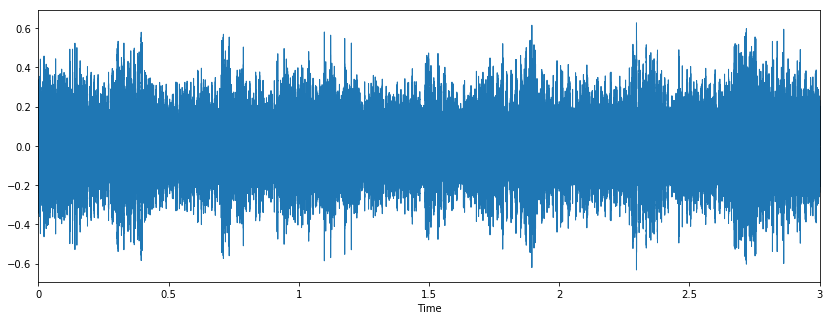

In [16]:
path = my_train_df.iloc[0].wav_path
x, sr = librosa.load(path, sr=16000)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

Wall time: 0 ns


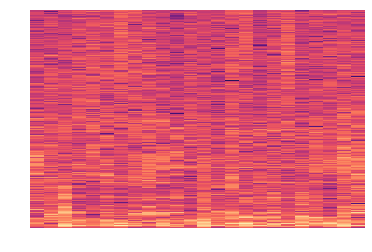

In [35]:
%time
cmap = plt.get_cmap('magma')

plt.specgram(x, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB')
plt.axis('off')
plt.savefig('img_train/img.png', dpi=20, bbox_inches = 'tight', pad_inches=0)


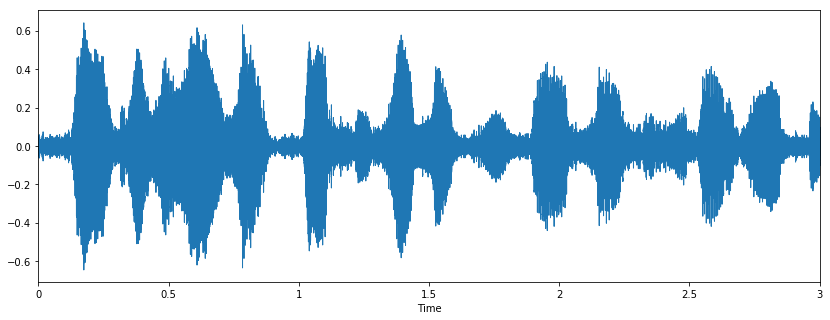

In [68]:
path = my_train_df.iloc[4].wav_path
x, sr = librosa.load(path, sr=16000)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

(32.0, 23072.0, 0.0, 1.0)

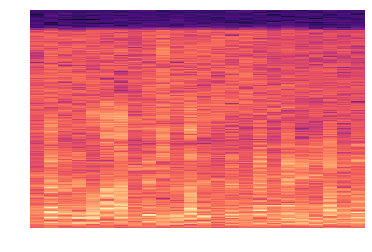

In [69]:
cmap = plt.get_cmap('magma')
plt.specgram(x, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB')
plt.axis('off')

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn import cluster

In [91]:
X = my_train_df.drop(columns=['wav_path', 'label', 'target'])#, 'chroma_stft', 'rmse', 'rolloff', 'spec_cent', 'spec_bw', 'zcr'])
y = my_train_df.target

In [92]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0)

In [11]:
import tensorflow as tf
from tensorflow import keras

In [70]:
y_test_ohe = keras.utils.to_categorical(y_test)
y_train_ohe = keras.utils.to_categorical(y_train)

In [94]:
y_ohe = keras.utils.to_categorical(y)

In [13]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


In [97]:
def build_model(layers):
    klayers = [keras.layers.Dense(layers[0], activation=tf.nn.relu, input_shape=(X.shape[1],)), keras.layers.Dropout(0.1), 
keras.layers.BatchNormalization()]
    for l in range(1, len(layers)):
        klayers.append(keras.layers.Dense(layers[l], activation=tf.nn.relu))
        klayers.append(keras.layers.Dropout(0.1))
        klayers.append(keras.layers.BatchNormalization())

    klayers.append(keras.layers.Dense(3, activation='softmax'))
    model = keras.Sequential(klayers)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=[f1_m, 'accuracy'])
    return model

In [98]:
model = build_model([256, 512, 512, 256])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 256)               6912      
_________________________________________________________________
dropout_54 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_v1_54 (B (None, 256)               1024      
_________________________________________________________________
dense_70 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_55 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_v1_55 (B (None, 512)               2048      
_________________________________________________________________
dense_71 (Dense)             (None, 512)               262656    
__________

In [99]:
es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(X, y_ohe, epochs=100, batch_size=32, callbacks=[es_callback])

Epoch 1/100
273000/273000 [==============================] - 65s 236us/sample - loss: 0.2133 - f1_m: 0.9235 - acc: 0.9235
Epoch 2/100
273000/273000 [==============================] - 64s 234us/sample - loss: 0.1611 - f1_m: 0.9430 - acc: 0.9430
Epoch 3/100
273000/273000 [==============================] - 65s 237us/sample - loss: 0.1450 - f1_m: 0.9489 - acc: 0.9488
Epoch 4/100
273000/273000 [==============================] - 65s 236us/sample - loss: 0.1362 - f1_m: 0.9525 - acc: 0.9524
Epoch 5/100
273000/273000 [==============================] - 65s 236us/sample - loss: 0.1307 - f1_m: 0.9538 - acc: 0.9537
Epoch 6/100
272896/273000 [============================>.] - ETA: 0s - loss: 0.1260 - f1_m: 0.9559 - acc: 0.95273000/273000 [==============================] - 65s 237us/sample - loss: 0.1260 - f1_m: 0.9559 - acc: 0.9559
Epoch 7/100
273000/273000 [==============================] - 65s 237us/sample - loss: 0.1215 - f1_m: 0.9573 - acc: 0.9572
Epoch 8/100
273000/273000 [=====================

X_sbmt = my_sbmt_df.drop(columns=['wav_path'])
X_sbmt = StandardScaler().fit_transform(X_sbmt)

In [100]:
y_sbmt = model.predict(X_sbmt)
y_sbmt = np.argmax(y_sbmt, axis=-1)
y_sbmt

array([2, 2, 0, ..., 1, 0, 0], dtype=int64)

In [101]:
sbmt_df.target = y_sbmt

In [102]:
sbmt_df.to_csv('my_submission_2.csv', index=False)

In [14]:
from scipy.io.wavfile import read

In [30]:
sr, x = read(my_train_df.iloc[0].wav_path)
y, _ = librosa.load(my_train_df.iloc[0].wav_path, sr=sr)
mfcc = librosa.feature.mfcc(y, sr, n_mfcc=20)
mfcc = np.expand_dims(mfcc, -1)
mfcc.shape

(20, 94, 1)

In [38]:
y[:, np.newaxis]

array([[ 0.0765686 ],
       [ 0.14700317],
       [ 0.19226074],
       ...,
       [-0.08895874],
       [-0.1003418 ],
       [-0.16513062]], dtype=float32)

In [35]:
y

array([ 0.0765686 ,  0.14700317,  0.19226074, ..., -0.08895874,
       -0.1003418 , -0.16513062], dtype=float32)

In [24]:
X = np.zeros((10,))
X

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
i = 0
for path in tqdm(my_train_df.wav_path):
    _, x = read(path)
    X[i,] = x
    i+=1

0                [1, 2, 3, 4]
1         train/e/3480542.wav
2         train/3/431313a.wav
3         train/a/7856ac7.wav
4         train/6/be92480.wav
                 ...         
272995    train/2/edfad8a.wav
272996    train/6/6a045ae.wav
272997    train/8/7c9760d.wav
272998    train/3/fa1d81c.wav
272999    train/6/fcfc8ce.wav
Name: wav_path, Length: 273000, dtype: object